# Explore different embedding spaces of Axiom data

Look at PCA and UMAP of Axiom data with different features. Explore how correlated the Dino and CP CNN features are.

In [1]:
# Imports
import polars as pl
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np

In [2]:
# Paths
feat_path = "/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect"
prof_path = f"{feat_path}/profiles/mad_featselect.parquet"

#prof_path = "/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/inputs/profiles/dino/raw.parquet"

In [235]:
data = pl.read_parquet(prof_path)

cc = pl.read_parquet(f"{feat_path}/curves/ccpods.parquet").filter(pl.col("all.pass") == True).select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_cc_POD"})
ldh = pl.read_parquet(f"{feat_path}/curves/ldhpods.parquet").filter(pl.col("all.pass") == True).select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_ldh_POD"})
mtt = pl.read_parquet(f"{feat_path}/curves/mttpods.parquet").filter(pl.col("all.pass") == True).select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_mtt_POD"})
morph = pl.read_parquet(f"{feat_path}/curves/pods.parquet").select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_morph_POD"})

data = data.join(cc, on="Metadata_Compound", how="left")
data = data.join(ldh, on="Metadata_Compound", how="left")
data = data.join(mtt, on="Metadata_Compound", how="left")
data = data.join(morph, on="Metadata_Compound", how="left")

In [236]:
# Add columns to label different sample subsets based on their bioactivity
data = data.with_columns(
    (pl.col("Metadata_Log10Conc") > pl.col("Metadata_morph_POD")).alias("Metadata_Bioactive"),
    (pl.col("Metadata_Log10Conc") < pl.col("Metadata_cc_POD")).alias("Metadata_No_Cytotox"),
)

data = data.with_columns(
    pl.when(pl.col("Metadata_Bioactive") == False)
    .then(False)
    .when(pl.col("Metadata_Bioactive") == True)
    .then(True)
    .otherwise(False)
    .alias("Metadata_Bioactive"),
)
data = data.with_columns(
    pl.when(pl.col("Metadata_No_Cytotox") == False)
    .then(False)
    .when(pl.col("Metadata_No_Cytotox") == True)
    .then(True)
    .otherwise(True)
    .alias("Metadata_No_Cytotox"),
)

metadata_cols = [col for col in data.columns if "Metadata" in col]

data = data.to_pandas()
data.sort_values(["Metadata_Plate", "Metadata_Well"], inplace=True)
data.index = [f"{row['Metadata_Plate']}__{row['Metadata_Well']}" for _, row in data.iterrows()]
data = data.loc[~data.index.duplicated(keep="first")]

metadata = data[metadata_cols]
adata = anndata.AnnData(X=data.drop(metadata_cols, axis=1))
adata.obs = adata.obs.merge(metadata, left_index=True, right_index=True)

# Plot UMAPs (only bioactive samples)
bioactive_mask = adata.obs["Metadata_Bioactive"]
adata_bioactive = adata[bioactive_mask].copy()
print(f"Bioactive samples: {adata_bioactive.shape}")

# Plot UMAPs (only bioactive & non-cytotoxic samples)
nocytotox_mask = adata_bioactive.obs["Metadata_No_Cytotox"]
adata_nocytotox = adata_bioactive[nocytotox_mask].copy()
print(f"Bioactive & non-cytotoxic samples: {adata_nocytotox.shape}")

Bioactive samples: (2981, 4432)
Bioactive & non-cytotoxic samples: (2177, 4432)


Probably showing batch at the tail ends of the cell count pattern, unless groups of compounds with similar MOA were put in the same batch. Those batches are mixed elsewhere, so perhaps this is the explanation. 

## Compare features

/Users/jewald/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/Users/jewald/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


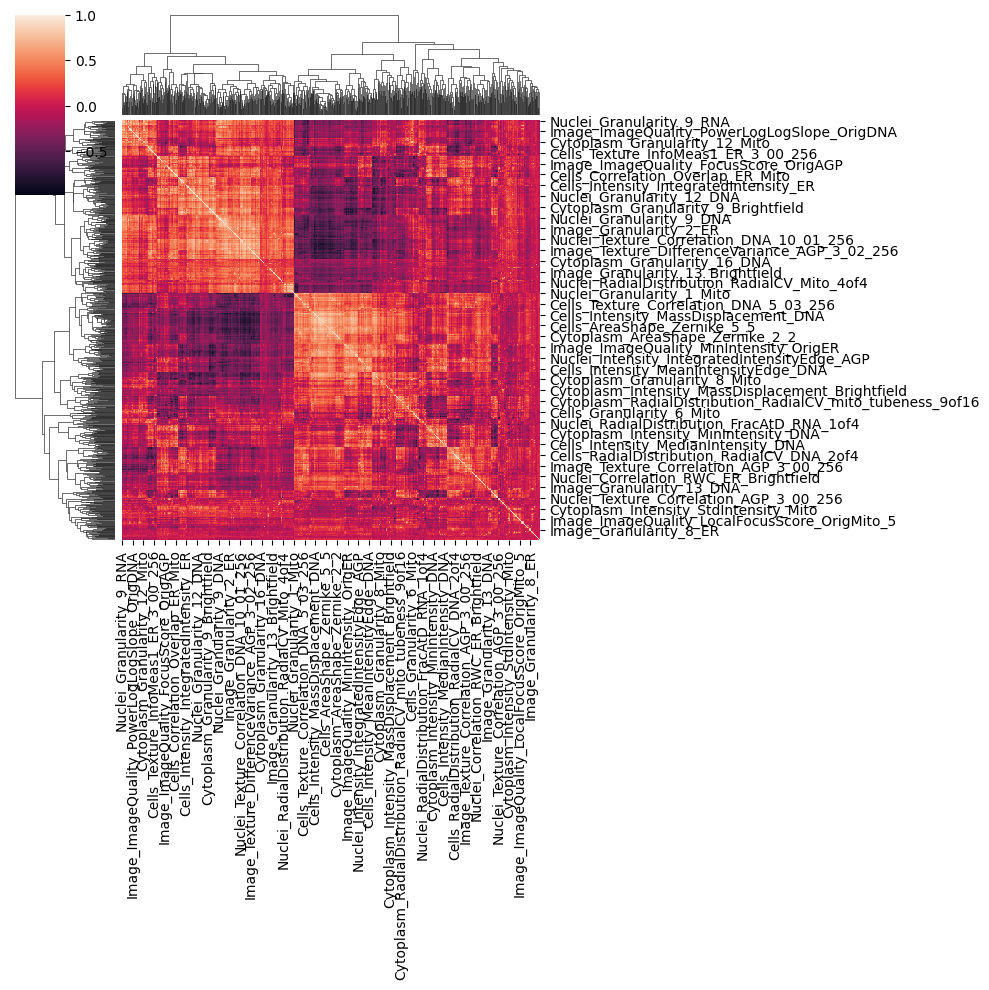

In [106]:
data_matrix = pl.DataFrame(adata.X.T).to_numpy()
correlation_matrix = np.corrcoef(data_matrix)
sns.clustermap(pd.DataFrame(correlation_matrix, index=adata.var_names, columns=adata.var_names), figsize=(10, 10))

In [42]:
# How many compounds had cell count decrease
cc = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/curves/ccpods.parquet")
print(f"cell count: {cc.select('all.pass').sum().item()}")

ldh = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/curves/ldhpods.parquet")
print(f"LDH: {ldh.select('all.pass').sum().item()}")

mtt = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/curves/mttpods.parquet")
print(f"MTT: {mtt.select('all.pass').sum().item()}")

morph = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/curves/pods.parquet")
print(f"morphology: {len(morph.select('Metadata_Compound').to_series().unique().to_list())}")

cell count: 220
LDH: 147
MTT: 428
morphology: 620


This makes sense - we expect morphology to pick up on more things than MTT/cell count/LDH, and we also expect less LDH than cell count since it is detecting a specific type of cell death (necrosis).

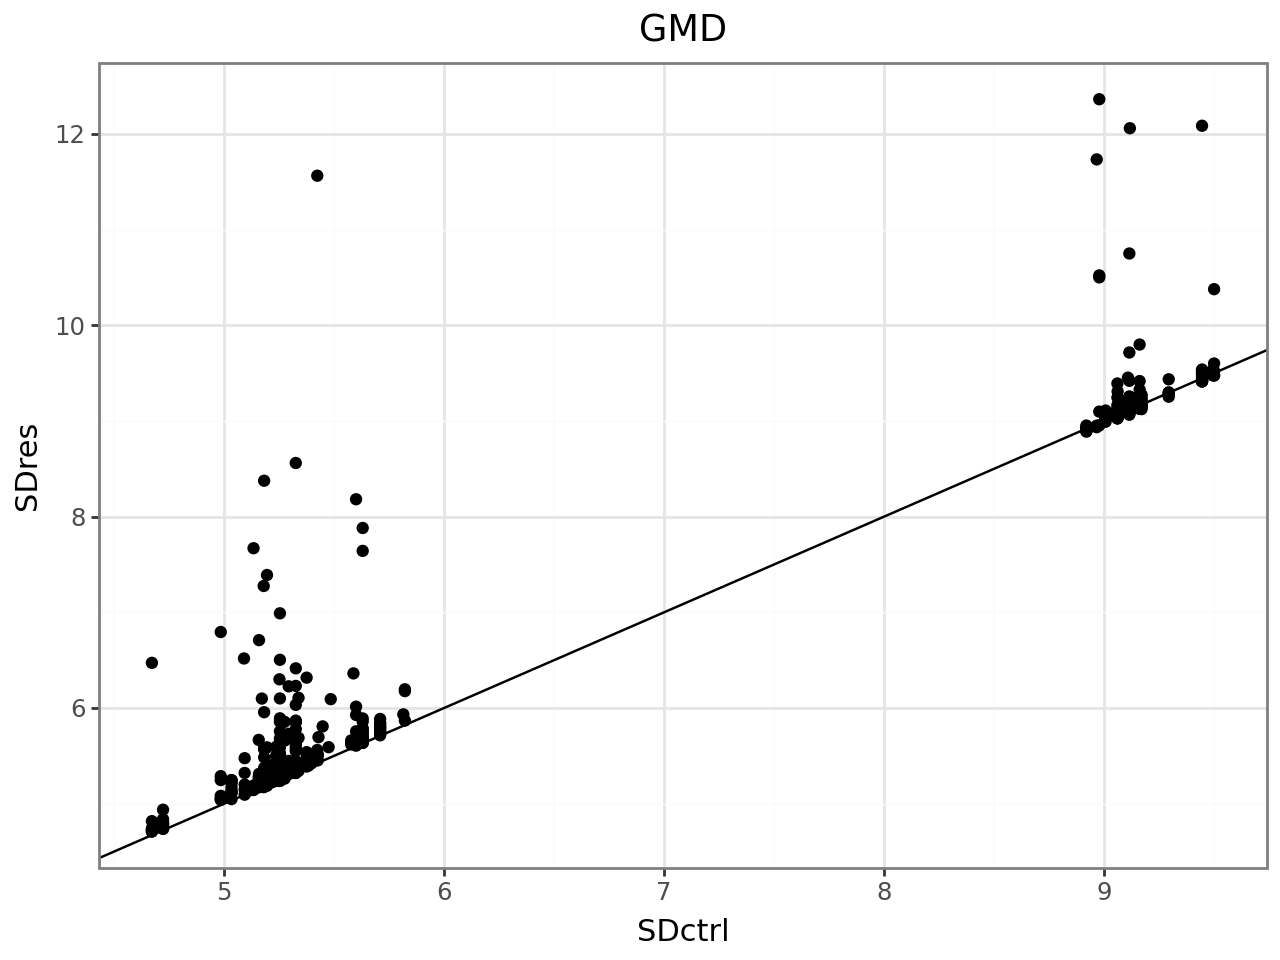

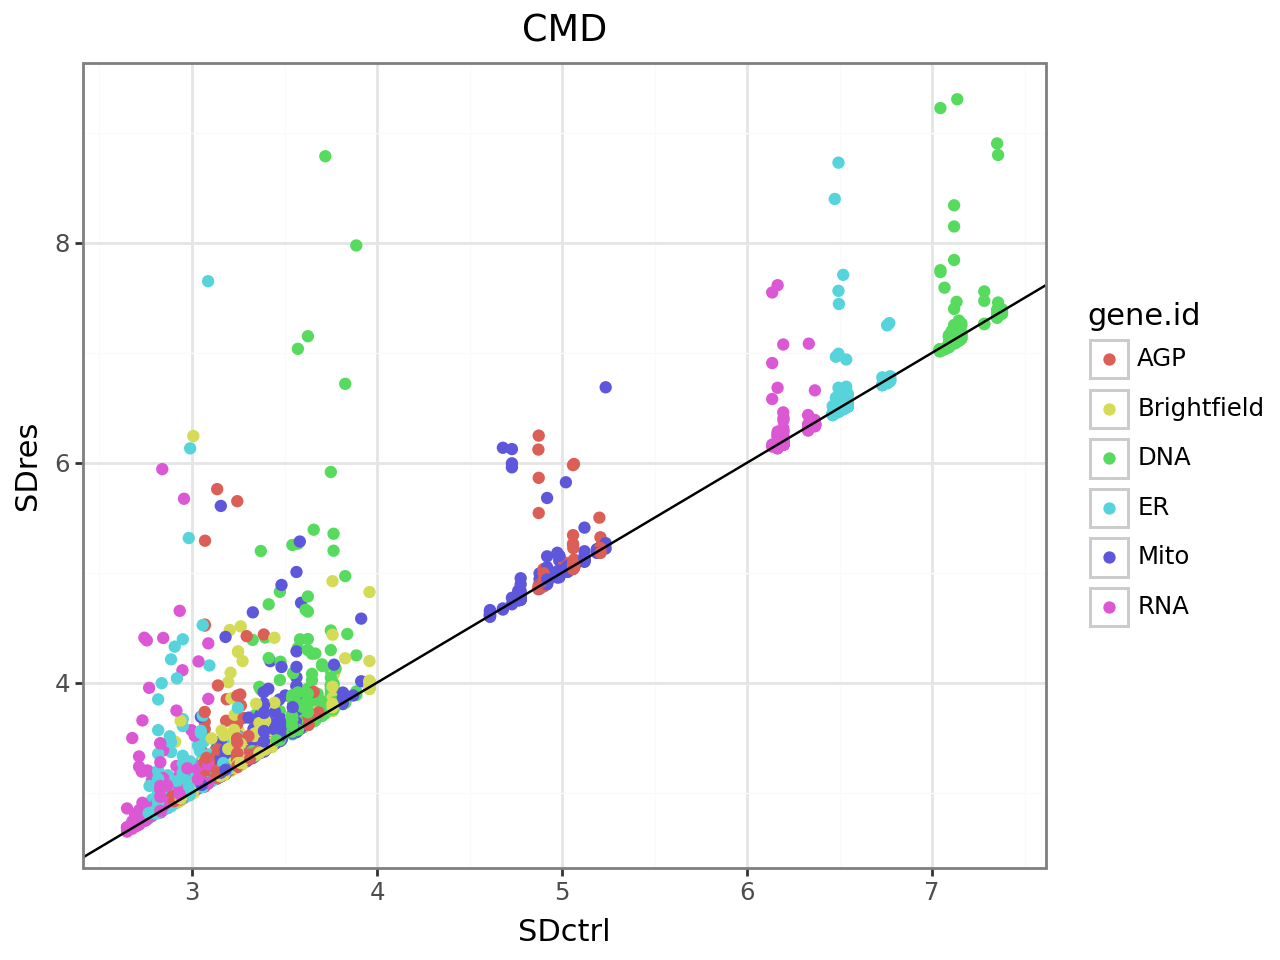

In [9]:
from plotnine import ggplot, geom_point, theme_bw, aes, labs, geom_abline, geom_boxplot, theme, element_text
import polars as pl

outputs = "../1_snakemake/outputs"

bmds = pl.read_parquet(f"{outputs}/dino/mad_featselect/curves/bmds.parquet")
bmds = bmds.filter((pl.col("conv.pass") == "true") & (pl.col("hd.pass") == "true") & (pl.col("CI.pass") == "true"))

bmd_gmd = bmds.filter(pl.col("gene.id") == "gmd")
bmd_cmd = bmds.filter(pl.col("gene.id") != "gmd")

plot = (ggplot(bmd_gmd, aes(x="SDctrl", y="SDres")) +
        geom_point() +
        theme_bw() +
        labs(title="GMD") +
        geom_abline(intercept=0, slope=1)
        )
plot.show()

plot = (ggplot(bmd_cmd, aes(x="SDctrl", y="SDres", color="gene.id")) +
        geom_point() +
        theme_bw() +
        labs(title="CMD") +
        geom_abline(intercept=0, slope=1)
        )
plot.show()

medians = (
    bmd_cmd.group_by("gene.id")
    .agg(pl.median("SDctrl").alias("median_SDctrl"))
    .sort("median_SDctrl")
).select("gene.id").to_series().to_list()

bmd_cmd = bmd_cmd.with_columns(
        pl.col("gene.id").cast(pl.Enum(medians))
)

plot = (ggplot(bmd_cmd, aes(x="gene.id", y="SDctrl")) +
        geom_boxplot() +
        theme_bw() +
        theme(axis_text_x=element_text(rotation=45, hjust=1)) +
        labs(title="CMD (SD control)")
        )
#plot.show()

In [31]:
# dino - gmd
bmds = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/curves/bmds.parquet")
bmds.filter(
    (pl.col("gene.id") == "gmd") & (pl.col("all.pass") == "true") & (pl.col("SDres") < 6)
).select("Metadata_Compound").to_series().unique().shape

(356,)

In [32]:
# cpcnn - only has gmd (WHY IS THIS DIFFERENT THAN ABOVE? --> because I have a random SDRES < 6 requirement in pod selection)
bmds = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/cpcnn/mad_featselect/curves/bmds.parquet")
bmds = bmds.filter(
    (pl.col("gene.id") == "gmd") & (pl.col("all.pass") == "true") & (pl.col("SDres") < 6)
)

bmds.select("Metadata_Compound").to_series().unique().shape

(353,)

In [34]:
# dino - including categorical
dino = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/curves/pods.parquet")
len(dino.select("Metadata_Compound").to_series().unique().to_list())

620

In [35]:
# cellprofiler - including categorical
cp = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/cellprofiler/mad_featselect/curves/pods.parquet")
len(cp.select("Metadata_Compound").to_series().unique().to_list())

589

## Look at distances

In [66]:
outputs = "../1_snakemake/outputs"

cellprofiler = pl.read_parquet(f"{outputs}/cellprofiler/mad_featselect/distances/gmd.parquet").filter(
    pl.col("Metadata_Compound") == "DMSO"
).select(["Metadata_Plate", "Metadata_source", "Metadata_Well", "Distance"]).with_columns(
        pl.lit("CellProfiler").alias("Metadata_Representation")
)

dino = pl.read_parquet(f"{outputs}/dino/mad_featselect/distances/gmd.parquet").filter(
    pl.col("Metadata_Compound") == "DMSO"
).select(["Metadata_Plate", "Metadata_source", "Metadata_Well", "Distance"]).with_columns(
        pl.lit("DINO").alias("Metadata_Representation")
)

cpcnn = pl.read_parquet(f"{outputs}/cpcnn/mad_featselect/distances/gmd.parquet").filter(
    pl.col("Metadata_Compound") == "DMSO"
).select(["Metadata_Plate", "Metadata_source", "Metadata_Well", "Distance"]).with_columns(
        pl.lit("CP-CNN").alias("Metadata_Representation")
)

gmds = pl.concat([cellprofiler, dino, cpcnn], how="vertical")

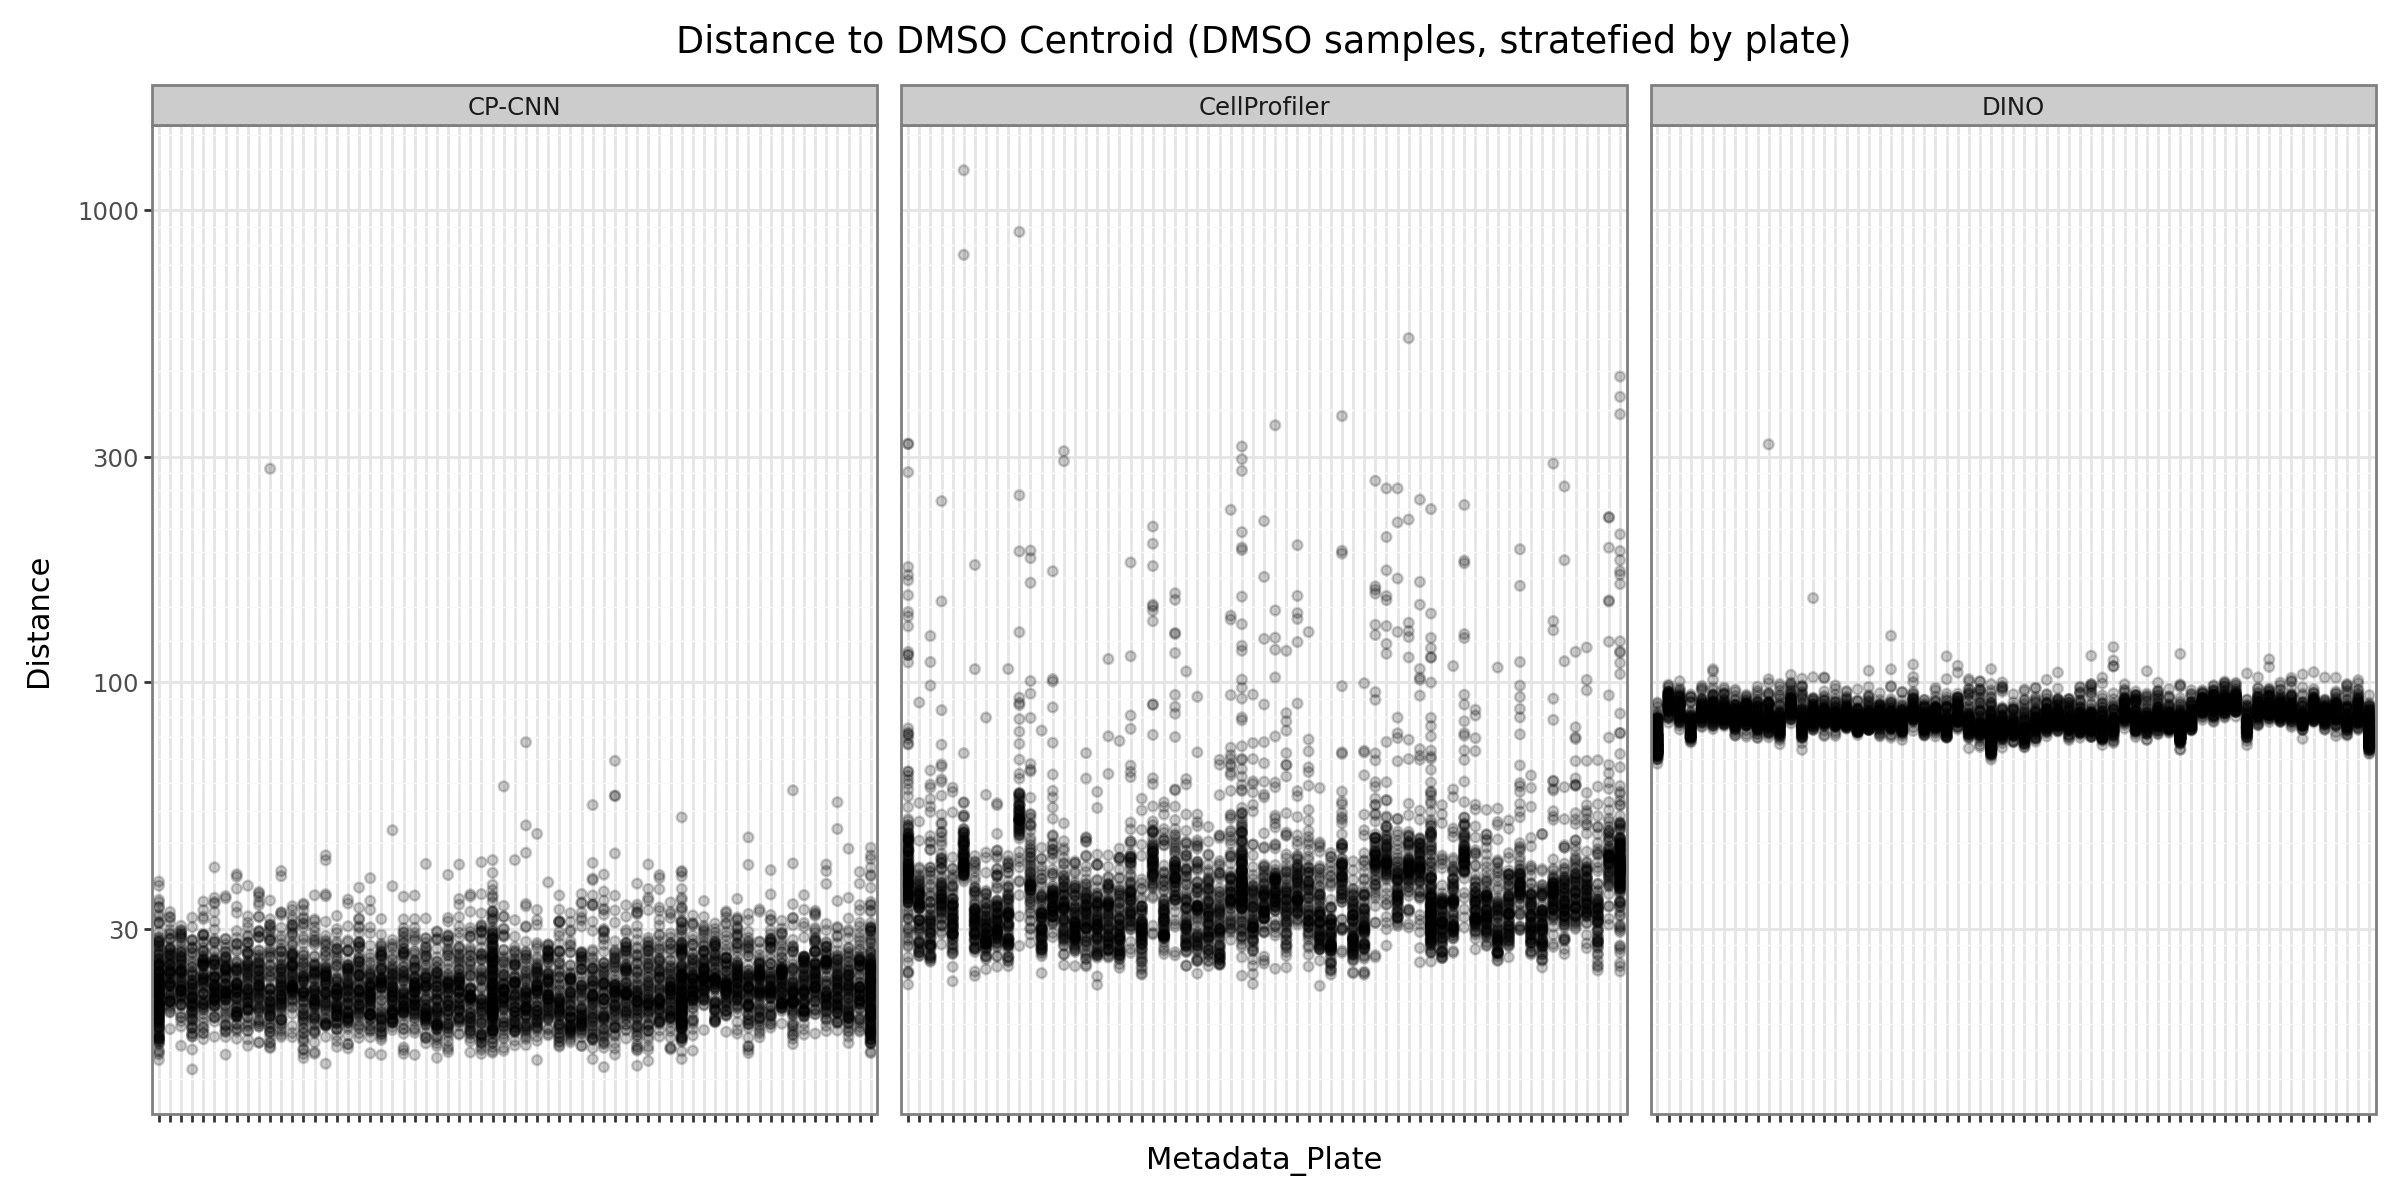

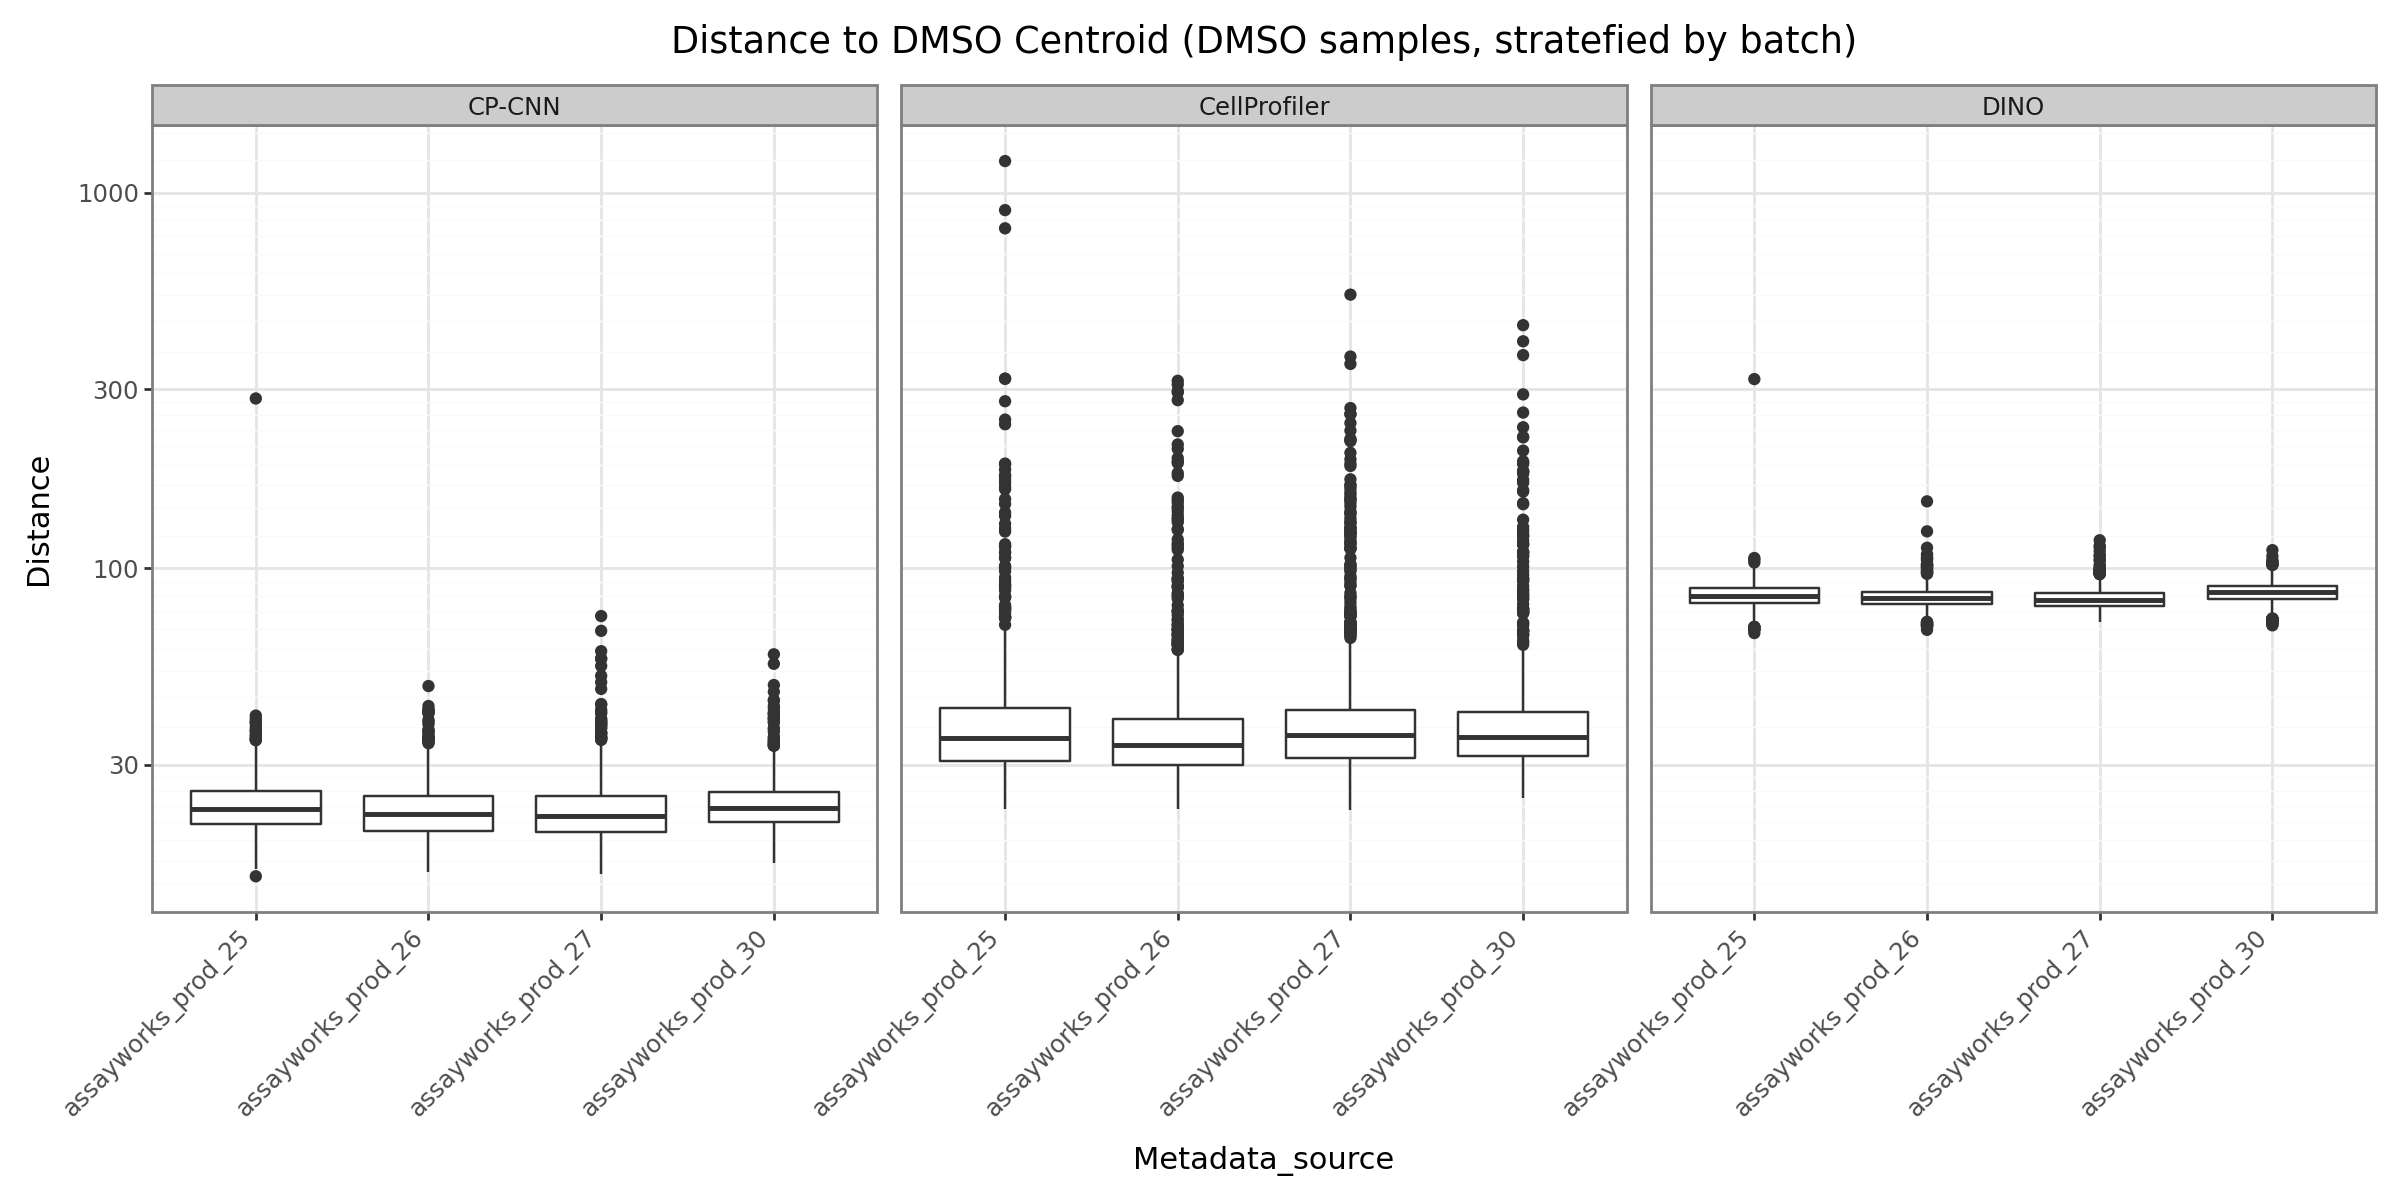

In [71]:
from plotnine import ggplot, geom_point, theme_bw, aes, labs, geom_abline, geom_boxplot, theme, element_text, geom_violin, scale_y_log10, facet_wrap, element_blank
import polars as pl
from plotnine import options
options.figure_size = (12, 6)

plot = (ggplot(gmds, aes(x="Metadata_Plate", y="Distance")) +
        geom_point(alpha=0.2) +
        theme_bw() +
        scale_y_log10() +
        facet_wrap("Metadata_Representation") +
        theme(axis_text_x=element_blank()) +
        labs(title="Distance to DMSO Centroid (DMSO samples, stratefied by plate)")
        )
plot.show()

plot = (ggplot(gmds, aes(x="Metadata_source", y="Distance")) +
        geom_boxplot() +
        theme_bw() +
        scale_y_log10() +
        facet_wrap("Metadata_Representation") +
        theme(axis_text_x=element_text(rotation=45, hjust=1)) +
        labs(title="Distance to DMSO Centroid (DMSO samples, stratefied by batch)")
        )
plot.show()

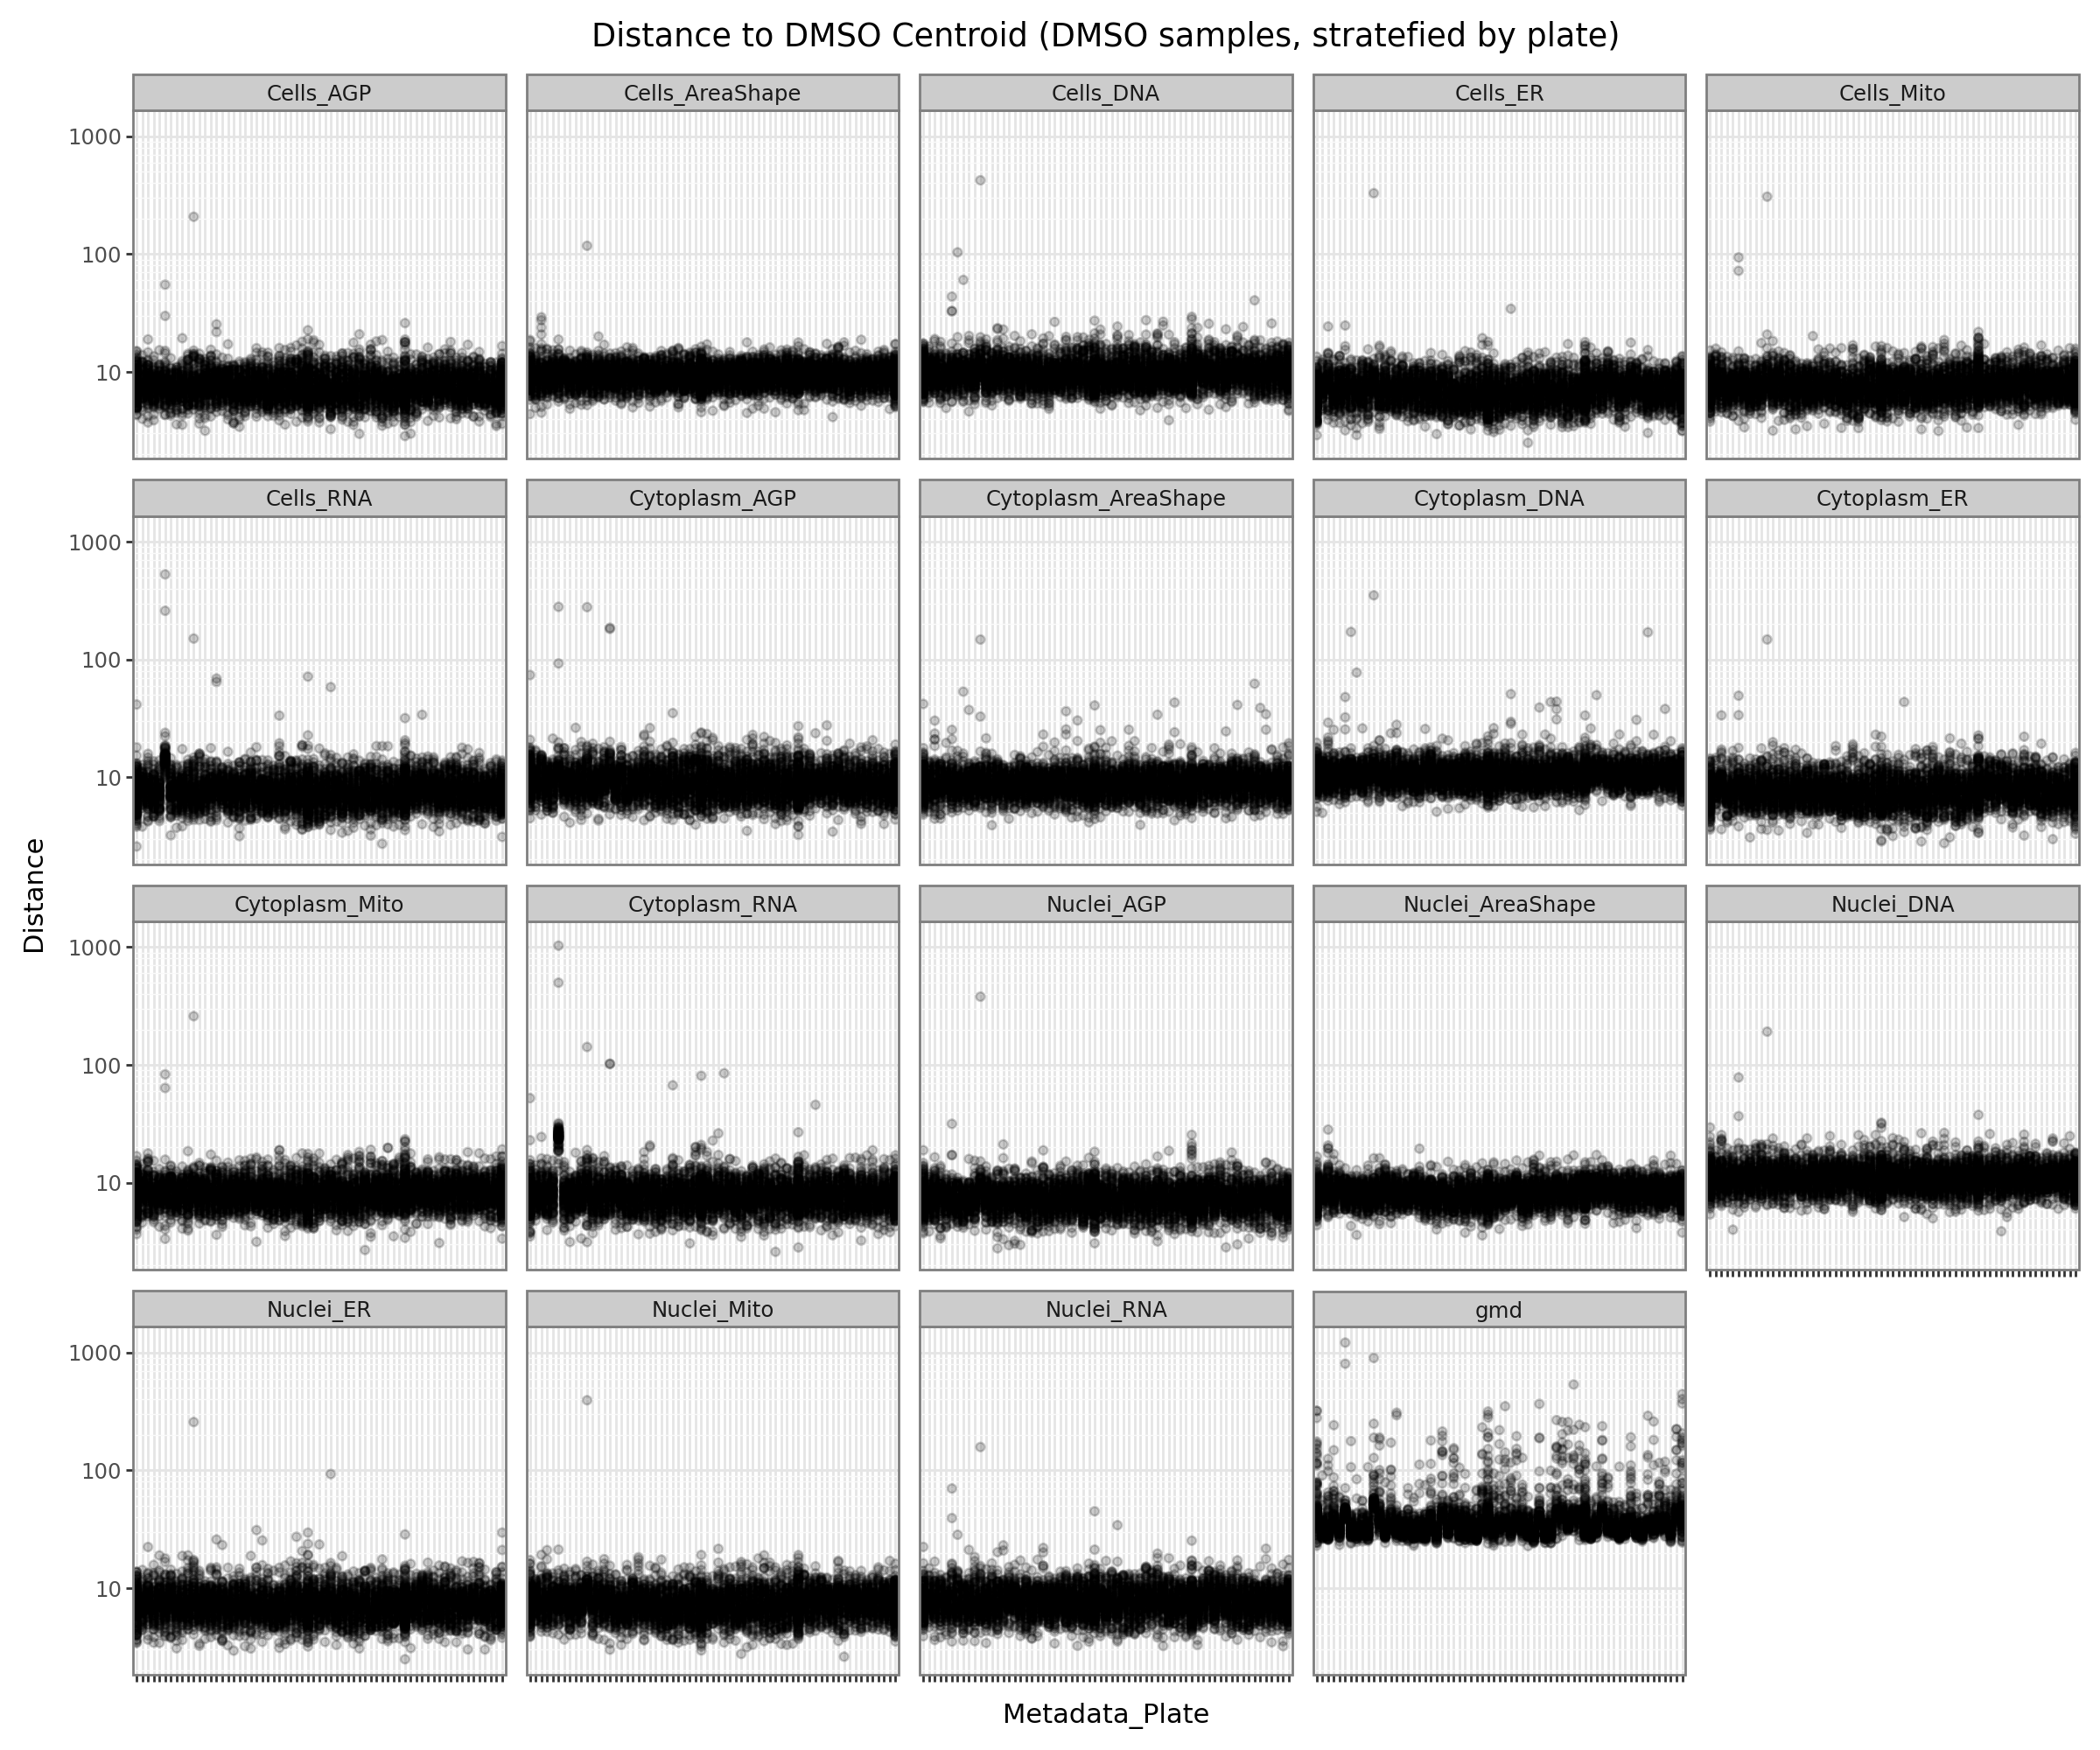

In [80]:
# Repeat for categories
cellprofiler_cmd = pl.read_parquet(f"{outputs}/cellprofiler/mad_featselect/distances/cmd.parquet").filter(
    pl.col("Metadata_Compound") == "DMSO"
).select(["Metadata_Plate", "Metadata_source", "Metadata_Well", "Distance", "Metadata_Distance"])

cellprofiler_gmd = pl.read_parquet(f"{outputs}/cellprofiler/mad_featselect/distances/gmd.parquet").filter(
    pl.col("Metadata_Compound") == "DMSO"
).select(["Metadata_Plate", "Metadata_source", "Metadata_Well", "Distance"]).with_columns(
    pl.lit("gmd").alias("Metadata_Distance")
)

cellprofiler_cmd = pl.concat([cellprofiler_gmd, cellprofiler_cmd], how="vertical")

options.figure_size = (12, 10)
plot = (ggplot(cellprofiler_cmd, aes(x="Metadata_Plate", y="Distance")) +
        geom_point(alpha=0.2) +
        theme_bw() +
        scale_y_log10() +
        facet_wrap("Metadata_Distance") +
        theme(axis_text_x=element_blank()) +
        labs(title="Distance to DMSO Centroid (DMSO samples, stratefied by plate)")
        )
plot.show()

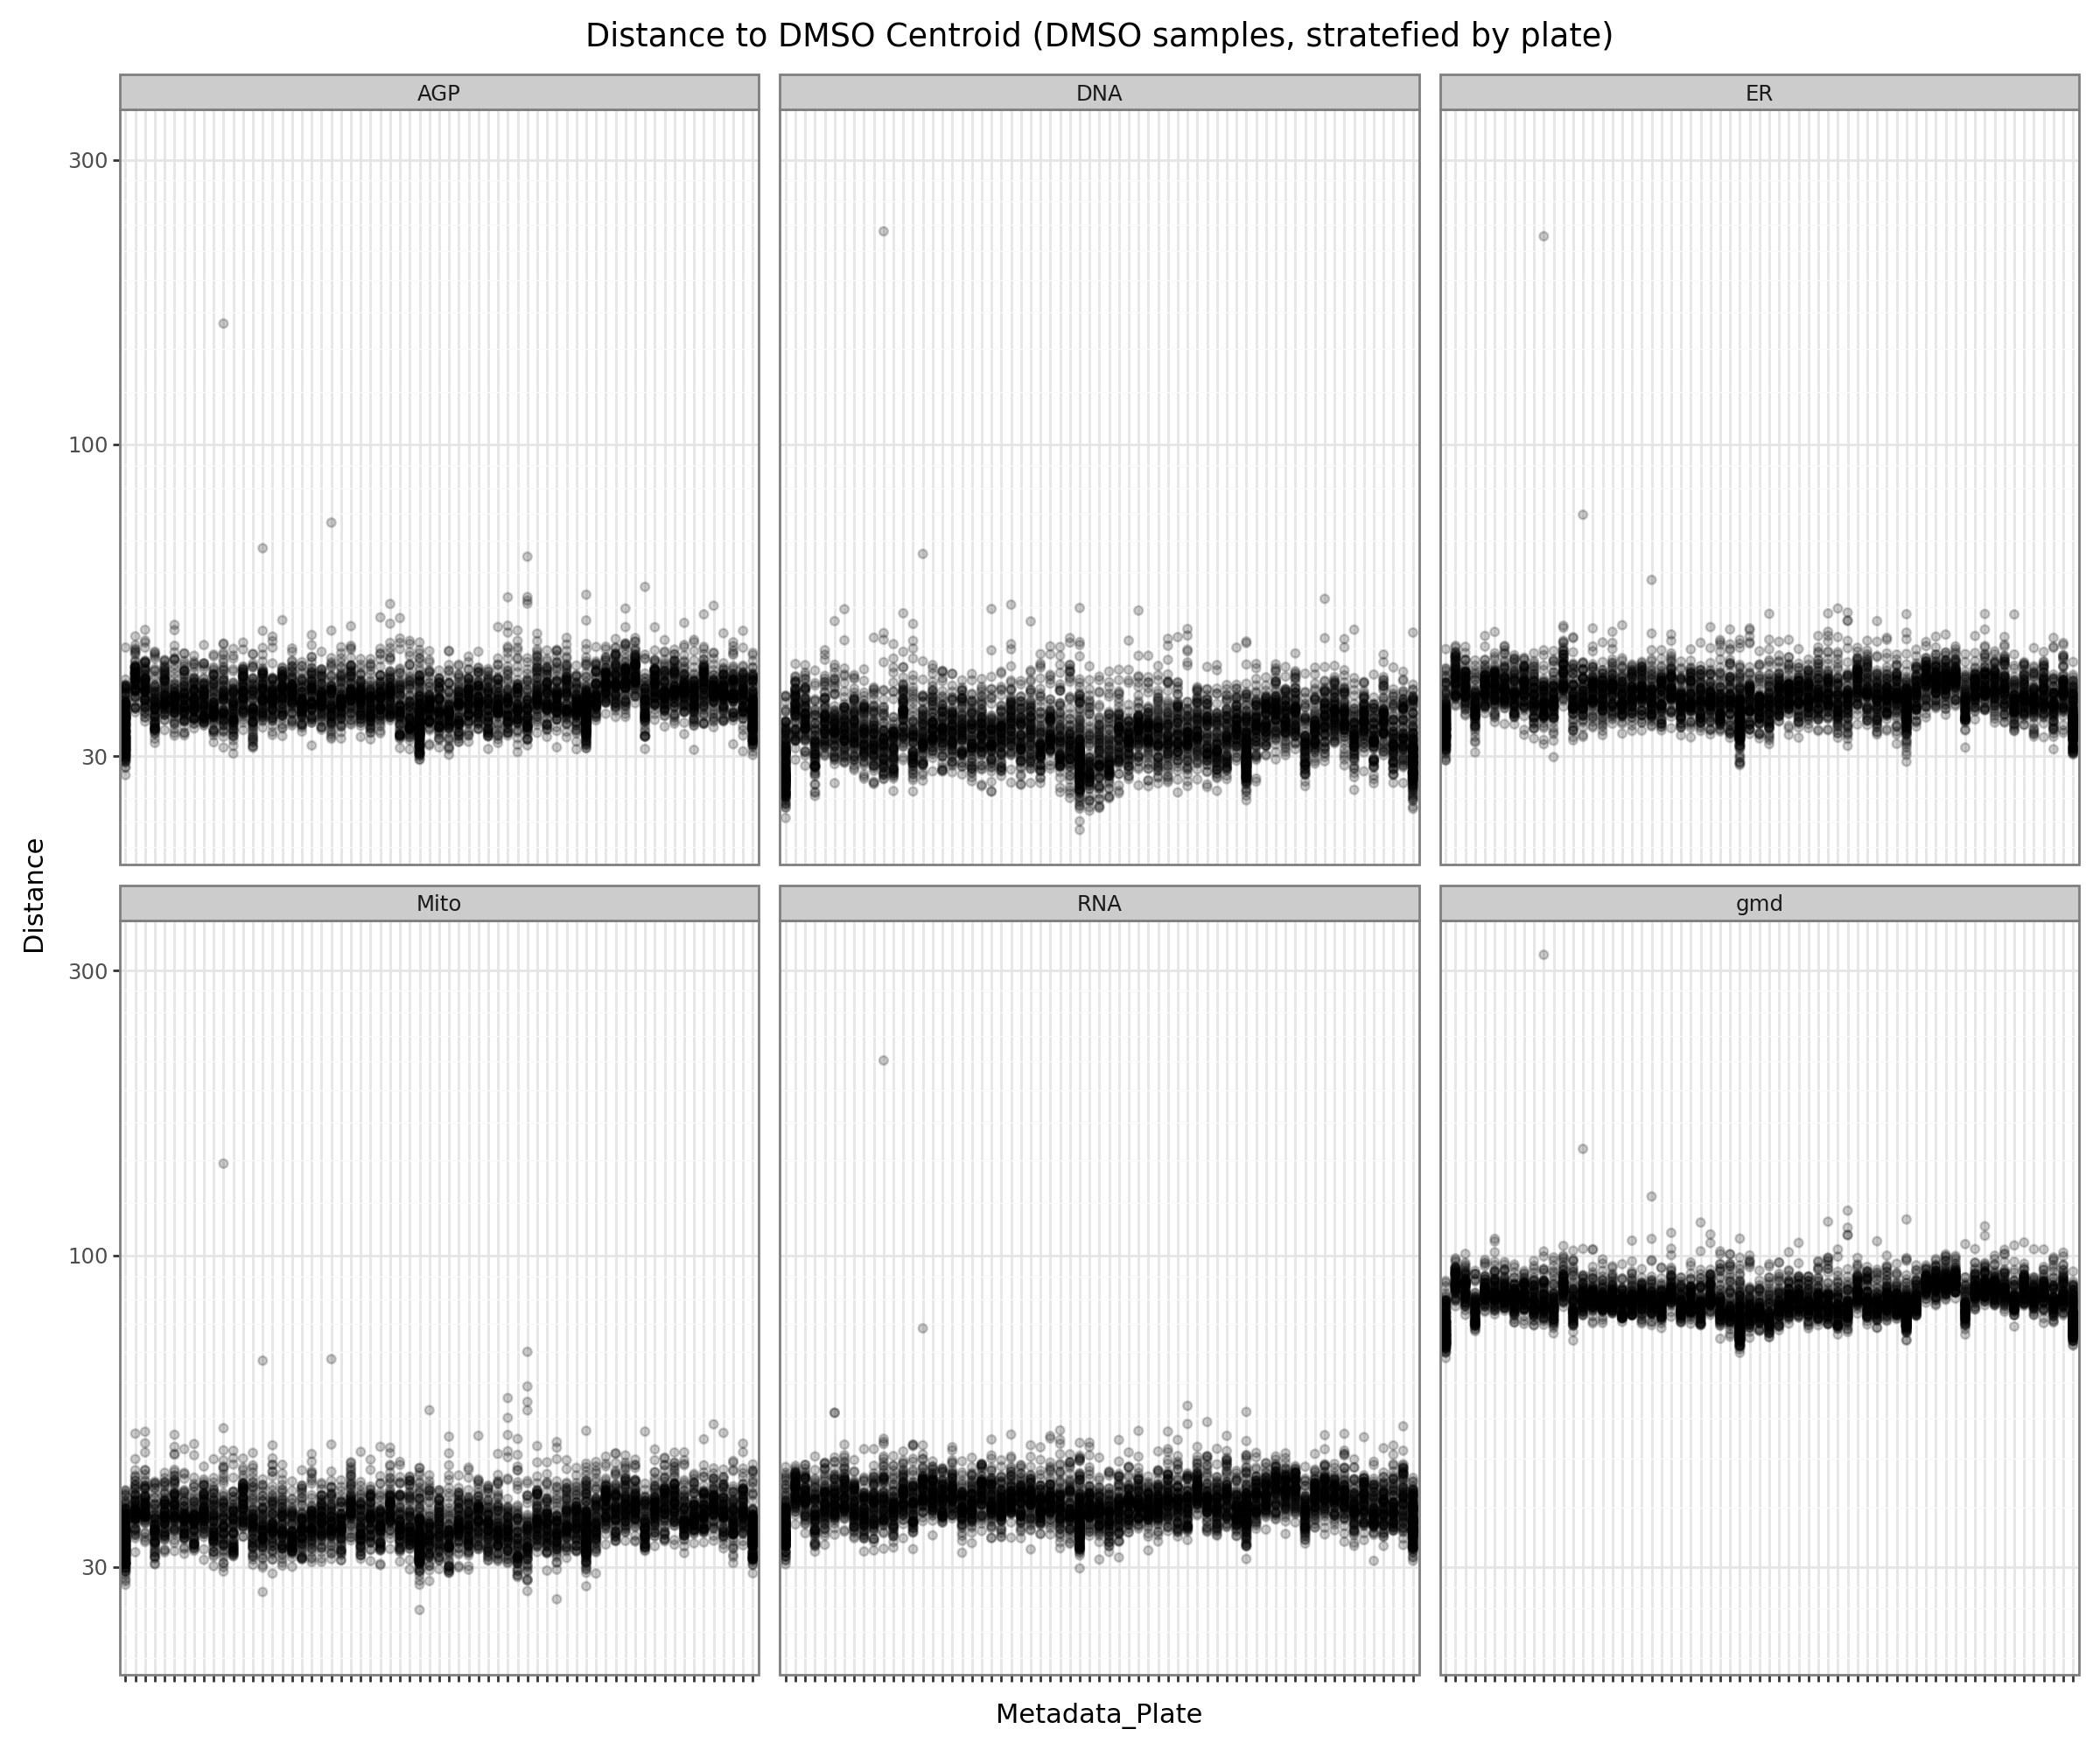

In [81]:
# Repeat for categories
dino_cmd = pl.read_parquet(f"{outputs}/dino/mad_featselect/distances/cmd.parquet").filter(
    pl.col("Metadata_Compound") == "DMSO"
).filter(pl.col("Metadata_Distance") != "Brightfield").select(["Metadata_Plate", "Metadata_source", "Metadata_Well", "Distance", "Metadata_Distance"])

dino_gmd = pl.read_parquet(f"{outputs}/dino/mad_featselect/distances/gmd.parquet").filter(
    pl.col("Metadata_Compound") == "DMSO"
).select(["Metadata_Plate", "Metadata_source", "Metadata_Well", "Distance"]).with_columns(
    pl.lit("gmd").alias("Metadata_Distance")
)

dino_cmd = pl.concat([dino_gmd, dino_cmd], how="vertical")

options.figure_size = (12, 10)
plot = (ggplot(dino_cmd, aes(x="Metadata_Plate", y="Distance")) +
        geom_point(alpha=0.2) +
        theme_bw() +
        scale_y_log10() +
        facet_wrap("Metadata_Distance") +
        theme(axis_text_x=element_blank()) +
        labs(title="Distance to DMSO Centroid (DMSO samples, stratefied by plate)")
        )
plot.show()

There are different characteristic Mahalonobis distances for different feature sets. This is probably related to the number of unique dimensions in the data - as the number of unique dimensions goes up, the average distance between two points increases. 

In this case, does the median DMSO Mahalanobis distance roughly correspond to the amount of information captured by the features? If this were true, then DINO would be capturing the most info (and be behaving the best), CP-CNN the least (but also behaving nicely), and CellProfiler slightly more than CP-CNN, but super noisy (right-skew, which is the same as noise when thinking about distance from DMSO centroid). 

Since ONLY CellProfiler gmd distances are super noisy (and not the various categories), is it possible that either the Image or cross-channel correlations are causing this noise? Should calculate the gmd distances after filtering out the features. 

Update: did this, and removing the non-cmd features (but not image features) decreases the overall MD variability (both the outliers and the median MD), but it's still far higher than the DINO and CP-CNN variability.

In [61]:
# Filter out DMSO outliers
gmd_thresh = np.percentile(gmds.select("Distance").to_numpy(), 97.5)
print(gmd_thresh)
dmso_outliers = gmds.filter(pl.col("Distance") > gmd_thresh)

33.9228


In [ ]:
# Filter out chem outliers
# This approach doesn't work well. 
# Get the residuals for the curve fit and identify samples where they are one of a few that are super different
dino_chem = pl.read_parquet(f"{outputs}/dino/mad_featselect/distances/gmd.parquet").filter(
    pl.col("Metadata_Compound") != "DMSO"
).select(["Metadata_Compound", "Metadata_Plate", "Metadata_source", "Metadata_Well", "Distance"])

dino_chem = dino_chem.group_by("Metadata_Compound").agg(
    pl.median("Distance").alias("Median"),
    pl.max("Distance").alias("Max"),
    (pl.col("Distance") - pl.median("Distance")).abs().median().alias("MAD"),
    pl.col("Distance").sort(descending=True).slice(1, 1).first().alias("Second_Highest")
)

dino_chem = dino_chem.with_columns(
    (pl.col("Second_Highest") + pl.col("MAD")*10).alias("Threshold"),
    (pl.col("Max")/pl.col("Second_Highest")).alias("Ratio")
)
dino_chem = dino_chem.with_columns(
    (pl.col("Max") > pl.col("Threshold")).alias("Filtered?")
)
dino_chem



shape: (1_085, 8)
┌─────────────────┬─────────┬─────────┬────────┬────────────────┬───────────┬──────────┬───────────┐
│ Metadata_Compou ┆ Median  ┆ Max     ┆ MAD    ┆ Second_Highest ┆ Threshold ┆ Ratio    ┆ Filtered? │
│ nd              ┆ ---     ┆ ---     ┆ ---    ┆ ---            ┆ ---       ┆ ---      ┆ ---       │
│ ---             ┆ f64     ┆ f64     ┆ f64    ┆ f64            ┆ f64       ┆ f64      ┆ bool      │
│ str             ┆         ┆         ┆        ┆                ┆           ┆          ┆           │
╞═════════════════╪═════════╪═════════╪════════╪════════════════╪═══════════╪══════════╪═══════════╡
│ Amifampridine   ┆ 92.7135 ┆ 97.286  ┆ 3.462  ┆ 96.565         ┆ 131.185   ┆ 1.007466 ┆ false     │
│ Zidovudine      ┆ 95.271  ┆ 104.15  ┆ 4.821  ┆ 103.799        ┆ 152.009   ┆ 1.003382 ┆ false     │
│ Haloperidol     ┆ 94.675  ┆ 451.756 ┆ 4.7445 ┆ 432.289        ┆ 479.734   ┆ 1.045032 ┆ false     │
│ Lusutrombopag   ┆ 94.195  ┆ 279.423 ┆ 6.0435 ┆ 274.186        ┆ 334.621   ┆ 1.0191   ┆ false     │
│ Compound_0b8601 ┆ 93.472  ┆ 111.928 ┆ 4.9805 ┆ 108.721        ┆ 158.526   ┆ 1.029498 ┆ false     │
│ 69              ┆         ┆         ┆        ┆                ┆           ┆          ┆           │
│ …               ┆ …       ┆ …       ┆ …      ┆ …              ┆ …         ┆ …        ┆ …         │
│ Etoposide       ┆ 92.8935 ┆ 103.696 ┆ 5.686  ┆ 101.213        ┆ 158.073   ┆ 1.024532 ┆ false     │
│ Levofloxacin    ┆ 93.477  ┆ 98.692  ┆ 2.1075 ┆ 97.028         ┆ 118.103   ┆ 1.01715  ┆ false     │
│ Selumetinib     ┆ 94.4215 ┆ 135.351 ┆ 5.4365 ┆ 115.301        ┆ 169.666   ┆ 1.173893 ┆ false     │
│ L-Ascorbic acid ┆ 94.1    ┆ 100.97  ┆ 3.913  ┆ 100.959        ┆ 140.089   ┆ 1.000109 ┆ false     │
│ Drometrizole    ┆ 91.8355 ┆ 124.898 ┆ 2.8465 ┆ 99.062         ┆ 127.527   ┆ 1.260806 ┆ false     │
└─────────────────┴─────────┴─────────┴────────┴────────────────┴───────────┴──────────┴───────────┘

In [ ]:
# Want to get rid of: 
# single, extreme outliers in the compound set
# DMSO extreme outliers (after 97.5th percentile)
# curve fitting when only the highest dose is affected, and much more strongly than the previous doses